In [ ]:
import tensorflow as tf
from tensorflow.keras import Input, Model, layers, initializers, optimizers, losses, preprocessing
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import os
import time
from google.colab import drive

DATASET_PATH = 'dataset/'
TRAINING_SET_SIZE = 2975
TEST_SET_SIZE = 500

In [ ]:
def fetch_dataset():
    drive.mount('/content/drive')
    !cp -r drive/MyDrive/JichoSmart/models .
    !mkdir plots
    !pip install kaggle
    !mkdir ~/.kaggle
    !touch ~/.kaggle/kaggle.json

    api_token = {"username": "badasstechie", "key": "17559c6155570222ecdcb9ecea36c1cb"}
    import json
    with open('/root/.kaggle/kaggle.json', 'w') as file:
        json.dump(api_token, file)

    !chmod 600 ~/.kaggle/kaggle.json
    !kaggle datasets download dansbecker/cityscapes-image-pairs
    !apt install unzip
    !unzip -q cityscapes-image-pairs.zip
    !mv cityscapes_data dataset

fetch_dataset()

def get_batch(batch_size):
    """grabs a batch from the dataset and loads it into memory"""
    indices = np.random.randint(1, TRAINING_SET_SIZE+1, size=batch_size)

    batch = preprocessing.image.load_img("{}train/{}.jpg".format(DATASET_PATH, indices[0]), target_size=(350,700))
    batch = preprocessing.image.img_to_array(batch)
    batch = np.expand_dims(batch, axis=0)

    for index in indices[1:]:
        filename = "{}train/{}.jpg".format(DATASET_PATH, index)
        image = preprocessing.image.load_img(filename, target_size=(350,700))
        image = preprocessing.image.img_to_array(image)
        image = np.expand_dims(image, axis=0)
        batch = np.append(batch, image, axis=0)

    batch = (batch.astype(np.float32) - 127.5)/ 127.5  #scale between -1 and 1, as generator activation function is tanh
    return batch[:, :256, :256, :], batch[:, :256, 350:606, :] #separate original and translated image


def test(generator, batch_size):
  """tests generator after some training iterations"""
  batch_x, batch_y = get_batch(batch_size)
  for y, x in zip(batch_y, batch_x):
    yhat = generator(np.expand_dims(x, 0))[0]
    plt.figure()
    fig, ax = plt.subplots(1, 3)
    ax[0].imshow((y+1.)/2)
    ax[1].imshow((x+1.)/2)
    ax[2].imshow((yhat+1.)/2)

  plt.show()


def format_time(seconds):
    """displays time as h:mm:ss"""
    return "{}:{:0>2}:{:0>2}".format(int(seconds//3600), int((seconds//60)%60), int(seconds%60))


Mounted at /content/drive
 96% 193M/202M [00:05<00:00, 41.5MB/s]
100% 202M/202M [00:05<00:00, 39.0MB/s]
Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [ ]:
def build_discriminator(image_shape=(256,256,3)):
    """patch discriminator"""
    init = initializers.RandomNormal(stddev=0.02)    # weight initialization
    in_src_image = Input(shape=image_shape)
    in_target_image = Input(shape=image_shape)
    merged = layers.Concatenate()([in_src_image, in_target_image]) # concatenate images channel-wise
    # C64
    y = layers.Conv2D(16, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(merged)
    y = layers.LeakyReLU(alpha=0.2)(y)
    # C128
    y = layers.Conv2D(32, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(y)
    y = layers.BatchNormalization()(y)
    y = layers.LeakyReLU(alpha=0.2)(y)
    # C256
    y = layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(y)
    y = layers.BatchNormalization()(y)
    y = layers.LeakyReLU(alpha=0.2)(y)
    # C512
    y = layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(y)
    y = layers.BatchNormalization()(y)
    y = layers.LeakyReLU(alpha=0.2)(y)
    # second last output layer
    y = layers.Conv2D(128, (4, 4), padding='same', kernel_initializer=init)(y)
    y = layers.BatchNormalization()(y)
    y = layers.LeakyReLU(alpha=0.2)(y)
    # patch output
    y = layers.Conv2D(1, (4, 4), padding='same', kernel_initializer=init)(y)
    patch_out = layers.Activation('sigmoid')(y)
    # define model
    model = Model([in_src_image, in_target_image], patch_out)
    return model

In [ ]:
def conv_block(x, num_filters, batchnorm=True):
    """convolution upsampling block(encoder)"""
    init = initializers.RandomNormal(stddev=0.02)
    y = layers.Conv2D(num_filters, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(x)
    if batchnorm:
        y = layers.BatchNormalization()(y, training=True)
    y = layers.LeakyReLU(alpha=0.2)(y)
    return y


def deconv_block(x, skip_connection, num_filters, dropout=True):
    """convolution downsampling block(decoder)"""
    init = initializers.RandomNormal(stddev=0.02)
    y = layers.Conv2DTranspose(num_filters, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(x)
    y = layers.BatchNormalization()(y, training=True)
    if dropout:
        y = layers.Dropout(0.5)(y, training=True)
    y = layers.Concatenate()([y, skip_connection])  # merge/stack with skip connection
    y = layers.Activation('relu')(y)
    return y


def build_generator(image_shape=(256,256,3)):
    """U-Net generator"""
    init = initializers.RandomNormal(stddev=0.02)
    in_image = Input(shape=image_shape)
    # convs
    c1 = conv_block(in_image, 16, batchnorm=False)
    c2 = conv_block(c1, 32)
    c3 = conv_block(c2, 64)
    c4 = conv_block(c3, 128)
    c5 = conv_block(c4, 128)
    c6 = conv_block(c5, 128)
    c7 = conv_block(c6, 128)
    # bottleneck, no batch norm and relu
    b = layers.Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(c7)
    b = layers.Activation('relu')(b)
    # deconvs
    d1 = deconv_block(b, c7, 128)   #skip connection with corresponding conv
    d2 = deconv_block(d1, c6, 128)
    d3 = deconv_block(d2, c5, 128)
    d4 = deconv_block(d3, c4, 128, dropout=False)
    d5 = deconv_block(d4, c3, 64, dropout=False)
    d6 = deconv_block(d5, c2, 32, dropout=False)
    d7 = deconv_block(d6, c1, 16, dropout=False)
    # output
    y = layers.Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
    out_image = layers.Activation('tanh')(y)
    # define model
    model = Model(in_image, out_image)
    return model

<Figure size 432x288 with 0 Axes>

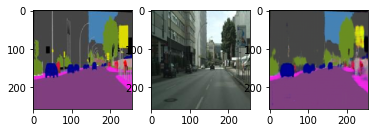

<Figure size 432x288 with 0 Axes>

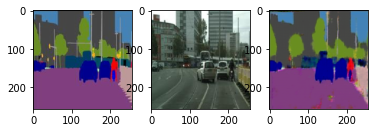

<Figure size 432x288 with 0 Axes>

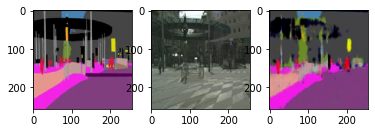

<Figure size 432x288 with 0 Axes>

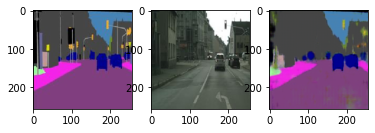

<Figure size 432x288 with 0 Axes>

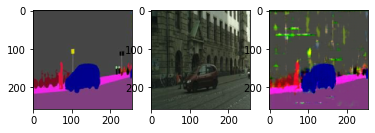

<Figure size 432x288 with 0 Axes>

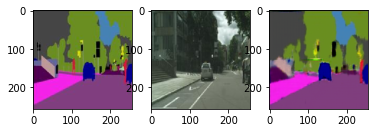

<Figure size 432x288 with 0 Axes>

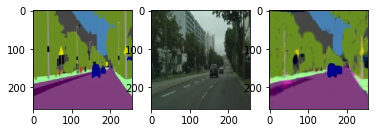

<Figure size 432x288 with 0 Axes>

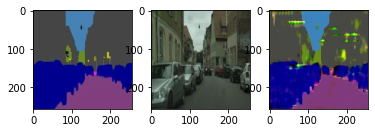

In [ ]:
generator = build_generator()
generator.load_weights("models/generator.h5")
test(generator, 8)

In [ ]:
@tf.function
def train_step(generator, discriminator, gen_optimizer, disc_optimizer, batch):
    """train step"""
    batch_org, batch_translated = batch
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_translated = generator(batch_org)

        batch_translated_logits = discriminator([batch_org, batch_translated])
        gen_translated_logits = discriminator([batch_org, gen_translated])
        batch_translated_labels = tf.ones(batch_translated_logits.shape, dtype=tf.float32)
        gen_translated_labels = tf.zeros(gen_translated_logits.shape, dtype=tf.float32)
        
        disc_logits = tf.concat([batch_translated_logits, gen_translated_logits], axis=0)
        disc_labels = tf.concat([batch_translated_labels, gen_translated_labels], axis=0)
        disc_loss = losses.binary_crossentropy(y_true=disc_labels, y_pred=disc_logits)

        #we use batch_translated_labels because we want the generator to fool the discriminator into thinking its images are real
        adversarial_loss = losses.binary_crossentropy(y_true=batch_translated_labels, y_pred=gen_translated_logits)
        l1_loss = losses.mean_absolute_error(y_true=batch_translated, y_pred=gen_translated) * 100
        gen_loss = 1 * tf.reduce_mean(adversarial_loss) + 100 * tf.reduce_mean(l1_loss) #l1 loss is weighted higher as it is smaller

    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

    return gen_loss, disc_loss


def train(batch_size=8, num_iterations=int(1e6), steps=1000, learning_rate=2e-4):
    """training loop (num_iterations has to be a multiple of steps or it will be truncated)"""
    generator = build_generator()
    discriminator = build_discriminator()
    gen_optimizer = optimizers.Adam(lr=learning_rate, beta_1=0.5)
    disc_optimizer = optimizers.Adam(lr=learning_rate * 0.5, beta_1=0.5)
    gen_loss_history = []
    disc_loss_history = []
    prev_time = time.time()
    time_elapsed = 0

    # load saved models or create if they don't exist
    if os.path.isfile("models/generator.h5"):
        generator.load_weights("models/generator.h5")
    else:
        generator.save_weights("models/generator.h5")

    if os.path.isfile("models/discriminator.h5"):
        discriminator.load_weights("models/discriminator.h5")
    else:
        discriminator.save_weights("models/discriminator.h5")

    print("Training...")

    for i in range(0, num_iterations, steps):
        for j in range(steps):
            batch = get_batch(batch_size)
            gen_loss, disc_loss = train_step(generator, discriminator, gen_optimizer, disc_optimizer, batch)
            gen_loss_history.append(gen_loss.numpy().mean())
            disc_loss_history.append(disc_loss.numpy().mean())

            time_elapsed += time.time() - prev_time
            prev_time = time.time()

        print("Iteration {}/{}. Time elapsed: {}\n".format(i + steps, num_iterations, format_time(time_elapsed)))

        # save checkpoints
        generator.save_weights("models/generator.h5")
        discriminator.save_weights("models/discriminator.h5")
        !cp -r /content/models /content/drive/MyDrive/JichoSmart
        !cp -r /content/plots /content/drive/MyDrive/JichoSmart

        # plot a graph that will show how our loss varied with time
        plt.plot(gen_loss_history, label="generator")
        plt.plot(disc_loss_history, label="discriminator")
        plt.legend(loc="upper right")
        plt.title("Training Progress")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.savefig(os.path.join("./plots", "Training Progress"))
        # plt.show()
        plt.close()

        #evaluate
        #test(generator, 1)

train()

Training...
Iteration 1000/1000000. Time elapsed: 0:01:38

Iteration 2000/1000000. Time elapsed: 0:03:20

Iteration 3000/1000000. Time elapsed: 0:05:02

Iteration 4000/1000000. Time elapsed: 0:06:44

Iteration 5000/1000000. Time elapsed: 0:08:29

Iteration 6000/1000000. Time elapsed: 0:10:05

Iteration 7000/1000000. Time elapsed: 0:11:38

Iteration 8000/1000000. Time elapsed: 0:13:22

Iteration 9000/1000000. Time elapsed: 0:15:06

Iteration 10000/1000000. Time elapsed: 0:16:39

Iteration 11000/1000000. Time elapsed: 0:18:23

Iteration 12000/1000000. Time elapsed: 0:20:08

Iteration 13000/1000000. Time elapsed: 0:21:53

Iteration 14000/1000000. Time elapsed: 0:23:38

Iteration 15000/1000000. Time elapsed: 0:25:25

Iteration 16000/1000000. Time elapsed: 0:27:10

Iteration 17000/1000000. Time elapsed: 0:28:55

Iteration 18000/1000000. Time elapsed: 0:30:39

Iteration 19000/1000000. Time elapsed: 0:32:26

Iteration 20000/1000000. Time elapsed: 0:34:03

Iteration 21000/1000000. Time elapsed

In [ ]:
def infer(path_to_image):
    """
        make inference

        :param path_to_image: path to input image
        :return: translated 256p image. remember to resize back to original size
    """
    image = preprocessing.image.load_img(path_to_image, target_size=(256,256))
    image = preprocessing.image.img_to_array(image)
    image = (image - 127.5) / 127.5 #scale between -1 and 1
    image = np.expand_dims(image, 0)    #add batch dimension
    generator = build_generator()
    generator.load_weights("models/generator.h5")
    translation = generator(image).numpy()[0]
    translation = translation * 127.5 + 127.5   #scale between 0 and 255
    return translation

# arr = infer("download.jfif")
# image = preprocessing.image.array_to_img(arr).resize((281,179))
# preprocessing.image.save_img("result.jpg", image)